In [1]:
from decimal import Decimal # for filenames

import pdb #Equivalent of keyboard in MATLAB, just add "pdb.set_trace()"

import os
import sys

In [2]:
###############################################################################
#                       HyperParameters and RunOptions                        #
###############################################################################
class Hyperparameters:
    max_hidden_layers = 7# For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  =100
    activation        = 'elu'
    classification_act= 'linear'
    model_constraint  =  25
    regularization    = 0.01
    manifold          = 0.000
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 500
    num_epochs        = 1000
    
    num_networks      = 6
    

In [3]:
import tensorflow as tf
from mat4py import loadmat
import numpy as np
import pandas as pd
from Utilities.plotting_sine import plot_sine
from Utilities.get_image_data import load_data
from Utilities.form_train_val_test_batches import form_train_val_test_batches
from Utilities.NN_FC_layerwise import FCLayerwise
from Utilities.NN_FC_layerwise_new import FCLayerwise_new
from Utilities.NETW import Final
from Utilities.Net import Final_Network
from Utilities.Net_new import Final_Network_ALGO_II
from Utilities.create_data import create_new
from Utilities.create_data_multiply import create_new_multiply
from Utilities.L2_error_computation import error_L2
from Utilities.loss_and_accuracies import data_loss_classification, data_loss_regression
from Utilities.manifold_regularization import manifold_classification
from Utilities.model_constraint import compute_interior_loss
from Utilities.model_constraint_weak import compute_interior_loss_weak
from Utilities.manifold_regularization_new import manifold_classification_new
from Utilities.optimize_layerwise import optimize
from Utilities.optimize_step_II import optimize_step
from Utilities.additive_output import net_output 
from Utilities.plot_and_save_figures_layerwise import plot_fig
from joblib import Parallel, delayed
import multiprocessing
import random

In [15]:
class Hyperparameters_new:
    max_hidden_layers = 3 # For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  = 20
    activation        = 'elu'
    classification_act= 'linear'
    regularization    = 0.000
    manifold          = 0.000
    model_constraint  =  60
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 500
    num_epochs        = 5000

In [5]:
class RunOptions:
    def __init__(self):    
        #=== Choose Which GPU to Use ===#
        self.which_gpu = '1'
        
        #=== Use L_1 Regularization ===#
        self.use_L1 = 1
        
        #=== Choose Data Set ===#
        self.data_MNIST = 0
        self.data_CIFAR10 = 0 
        self.data_CIFAR100 = 0
        self.data_regression=1
        
        #=== Random Seed ===#
        self.random_seed = 1234


In [6]:
###############################################################################
#                                 File Paths                                  #
###############################################################################         
class FilePaths():    
    def __init__(self, hyperp, run_options):  
        #=== Declaring File Name Components ===# 
        self.NN_type = 'FC'
        if run_options.data_MNIST == 1:
            self.dataset = 'MNIST'
        if run_options.data_CIFAR10 == 1:
            self.dataset = 'CIFAR10'
        if run_options.data_CIFAR100 == 1:
            self.dataset = 'CIFAR100'
        if run_options.data_regression == 1:
            self.dataset = 'Abalone'
        if hyperp.regularization >= 1:
            hyperp.regularization = int(hyperp.regularization)
            regularization_string = str(hyperp.regularization)
        else:
            regularization_string = str(hyperp.regularization)
            regularization_string = 'pt' + regularization_string[2:]                        
        node_TOL_string = str('%.2e' %Decimal(hyperp.node_TOL))
        node_TOL_string = node_TOL_string[-1]
        error_TOL_string = str('%.2e' %Decimal(hyperp.error_TOL))
        error_TOL_string = error_TOL_string[-1]
        
        #=== File Name ===#
        if run_options.use_L1 == 0:
            self.filename = self.dataset + '_' + self.NN_type + '_mhl%d_hl%d_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)
        else:
            self.filename = self.dataset + '_' + self.NN_type + '_L1_mhl%d_hl%d_r%s_nTOL%s_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, regularization_string, node_TOL_string, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)

        #=== Saving Trained Neural Network and Tensorboard ===#
        #self.NN_savefile_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Trained_NNs/' + self.filename # Since we need to save four different types of files to save a neural network model, we need to create a new folder for each model
        self.NN_savefile_directory =  self.filename
        self.NN_savefile_name = self.NN_savefile_directory + '/' + self.filename # The file path and name for the four files
        #self.tensorboard_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Tensorboard/' + self.filename

###############################################################################



In [ ]:
if __name__ == "__main__":     

    trainable=2
    #=== Hyperparameters and Run Options ===#    
    hyperp = Hyperparameters()
    hyperp_new=Hyperparameters_new()
    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 
    
    gauss_solution=np.loadtxt("gauss_solution.data")
    gauss_solution = tf.cast(gauss_solution,tf.float32)
    
    gauss_points = loadmat('gauss_points.mat')
    gauss_points=np.array(list(gauss_points.values()))[-1]
    gauss_points = tf.cast(gauss_points,tf.float32)
    
    gauss_points_new = loadmat('gauss_points_new.mat')
    gauss_points_new=np.array(list(gauss_points_new.values()))[-1]
    gauss_points_new = tf.cast(gauss_points_new,tf.float32)
    
    gauss_weights = loadmat('gauss_weights.mat')
    gauss_weights=np.array(list(gauss_weights.values()))[-1].squeeze(-1)
    
    gauss_weights_new = loadmat('gauss_weights_new.mat')
    gauss_weights_new=np.array(list(gauss_weights_new.values()))[-1].squeeze(-1)

    
    Coordinates = loadmat('Coordinates.mat')
    Coordinates=np.array(list(Coordinates.values()))[-1]
    Coordinates = tf.cast(Coordinates,tf.float32)
    
    
    Stiffness = loadmat('Stiffness.mat')
    Stiffness=np.array(list(Stiffness.values()))[-1]
    Stiffness = tf.cast(Stiffness,tf.float32)
    
    load = loadmat('observation.mat')
    load=np.array(list(load.values()))[-1]
    load=tf.cast(load,tf.float32)
    load=tf.reshape(load,(len(load),1))
    
    Solution = loadmat('Solution.mat')
    Solution=np.array(list(Solution.values()))[-1]
    Solution=tf.cast(Solution,tf.float32)
    Solution=tf.reshape(Solution,(len(Solution),1))
    
    

    v=[]
    for i in range(0,len(Solution)):
        if np.abs(Solution[i])<1e-10:
            v.append(i)
    
    #for i in range(1,hyperp.num_networks):
    for i in range(4,5):
    #=== Initiate training ===#
        #trainer(hyperp, run_options, file_paths,i) 
        if i>1:
            trainable=2

    
            
        if trainable==2:
        
        
        
            #=== GPU Settings ===#
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
            os.environ["CUDA_VISIBLE_DEVICES"] = run_options.which_gpu
    
            #=== Neural Network ===#
            if run_options.use_L1 == 0:
                kernel_regularizer = None
                bias_regularizer = None  
            else:
                kernel_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
                bias_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
            
            
            multiply=0
        
            if multiply==0:

                data_train,new_label,labels_train,load,Solution=create_new(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,i,load,Stiffness,Coordinates,Solution)
        
            if multiply==1:

                data_train,new_label,labels_train=create_new_multiply(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,i)
     
        #=== Construct Validation Set and Batches ===# 
            data_and_labels_train, data_and_labels_val, data_and_labels_test,\
            num_data_train, num_data_val, num_data_test,\
            num_batches_train, num_batches_val, num_batches_test,data_and_labels_train_new\
            = form_train_val_test_batches(data_train, labels_train, \
                                      data_test, labels_test, \
                                      hyperp.batch_size, new_label, run_options.random_seed)
        
        
        if i==1 and trainable==2:
            NN = FCLayerwise(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer)    
            NN._set_inputs( data_train)
        if i>1:
            kernel_regularizer = None
            bias_regularizer = None
            NN = FCLayerwise_new(hyperp_new, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer) 
            NN._set_inputs( data_train)
    #=== Training ===#
    #                                 Training                                    #
###############################################################################
        if trainable>2:
            del NN
            NN = Final(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer,trainable)   
            #NN._set_inputs(data_train)
            NN.load_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(trainable-1))
            #NN=tf.keras.models.load_model("WEIGHTS"+'/'+"model"+str(1)+str(trainable-1))
        


        if i==1:
            hyperp_n=hyperp
            optimize(hyperp,hyperp_n, run_options, file_paths, NN, data_loss_classification, data_loss_regression, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape,data_train,labels_train,multiply,trainable,compute_interior_loss,gauss_points,gauss_weights,error_L2,gauss_solution,gauss_points_new,gauss_weights_new,Coordinates, Stiffness, load,Solution,v)   
        
        if i>1:
            hyperp_n=Hyperparameters_new()
            optimize_step(hyperp,hyperp_n, run_options, file_paths, NN, data_loss_classification, data_loss_regression, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification_new,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape,data_train,labels_train,multiply,compute_interior_loss,gauss_points,gauss_weights,error_L2,gauss_solution,gauss_points_new,gauss_weights_new,Coordinates, Stiffness, load,Solution,v)   
        
        #NN.save("WEIGHTS"+'/'+"model"+str(1)+str(trainable))
        if not os.path.exists("WEIGHTS"):
            os.makedirs("WEIGHTS")
        NN.save_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(trainable))
        
        if i==1:
            plot_fig(hyperp, run_options, file_paths,i,trainable+1)
            
        if i>1:
            plot_fig(hyperp_new, run_options, file_paths,i,3)
        
        
        #plot_sine(hyperp,hyperp_new, data_test, run_options, data_input_shape, label_dimensions,2,data_train, labels_train)
        
   
        
        
        
        
        
        
        
        

Beginning Training
            Epoch 0            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Model: "fc_layerwise_new_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
W2 (Dense)                   multiple                  420       
_________________________________________________________________
upsampling_layer (Dense)     multiple                  60        
_________________________________________________________________
classification_layer (Dense) multiple                  21        
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Time per Batch: 0.30
Time per Epoch: 2.68

Training Set: Loss: 1.853e-02, Accuracy: 35.141
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer R

Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.936
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 17            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.940
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 18            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.854e-02, Accuracy: 34.935
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            E

Time per Epoch: 2.28

Training Set: Loss: 1.854e-02, Accuracy: 34.935
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 35            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.939
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 36            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.935
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            E

Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.934
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 53            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.937
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 54            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.934
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            E

Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.934
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 71            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.936
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 72            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.934
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            E

Time per Epoch: 2.25

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 89            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.854e-02, Accuracy: 34.936
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 90            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            E

Time per Epoch: 2.25

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 107            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.06
Time per Epoch: 2.19

Training Set: Loss: 1.854e-02, Accuracy: 34.935
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 108            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.934
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.28

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 125            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.935
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 126            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 143            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.854e-02, Accuracy: 34.935
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 144            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 161            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.935
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 162            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.934
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 179            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 180            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.935
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.29

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 197            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.934
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 198            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 215            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.854e-02, Accuracy: 34.934
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 216            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.934
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 233            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 234            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 251            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.934
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 252            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.25

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 269            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 270            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.854e-02, Accuracy: 34.934
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.25

Training Set: Loss: 1.854e-02, Accuracy: 34.934
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 287            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 288            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.934
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 305            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 306            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 323            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 324            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 341            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 342            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 359            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 360            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.37

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 377            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.06
Time per Epoch: 2.29

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 378            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 395            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 396            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.30

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 413            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 414            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.31

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.27

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 431            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 432            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 449            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 450            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.19

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 467            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 468            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 485            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 486            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 503            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 504            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 521            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 522            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 539            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 540            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 557            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 558            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 575            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 576            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 593            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 594            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 611            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 612            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 629            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 630            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 647            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 648            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 665            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 666            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 683            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 684            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 701            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 702            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.56

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 719            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 720            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 737            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 738            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 755            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 756            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.30

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 773            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 774            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 791            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 792            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 809            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 810            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.34

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 827            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 828            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.35

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 845            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 846            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.18

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 863            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 864            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.06
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 881            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.31

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 882            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 899            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 900            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 917            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.36

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 918            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 935            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 936            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 953            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 954            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.31

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 971            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 972            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 989            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 990            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

           

Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1007            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1008            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.45

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1025            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.56

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1026            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.71

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1043            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1044            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1061            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1062            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1079            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1080            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.933
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1097            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1098            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1115            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1116            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1133            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1134            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.06
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1151            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1152            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.30

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1169            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1170            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1187            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1188            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1205            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1206            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1223            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1224            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1241            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1242            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1259            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1260            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1277            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1278            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1295            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1296            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1313            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1314            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1331            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1332            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1349            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1350            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.31

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1367            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1368            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1385            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1386            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1403            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1404            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1421            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.30

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1422            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.18

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1439            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1440            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1457            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1458            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1475            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1476            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1493            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1494            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1511            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1512            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1529            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1530            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1547            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1548            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.30

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1565            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.31

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1566            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.06
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.18

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1583            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1584            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1601            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1602            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.15

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1619            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1620            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1637            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1638            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1655            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1656            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1673            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1674            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.06
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.25

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1691            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1692            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1709            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1710            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.35

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1727            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1728            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1745            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1746            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1763            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1764            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1781            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1782            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1799            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1800            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1817            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1818            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1835            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1836            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1853            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1854            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.30

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1871            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1872            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1889            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1890            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1907            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1908            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1925            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.18

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1926            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.33

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1943            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1944            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1961            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1962            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1979            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1980            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1997            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1998            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2015            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2016            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2033            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.36

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2034            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2051            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2052            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2069            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2070            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.38

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2087            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2088            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2105            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2106            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2123            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2124            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.30

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2141            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2142            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.31

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2159            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2160            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.18

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2177            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.17

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2178            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.18

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2195            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2196            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2213            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2214            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2231            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2232            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2249            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2250            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2267            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2268            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2285            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2286            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2303            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2304            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2321            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2322            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2339            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2340            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.32

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2357            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2358            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2375            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2376            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2393            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2394            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2411            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2412            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2429            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.06
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2430            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2447            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2448            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2465            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2466            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.18

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2483            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2484            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2501            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2502            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.25

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2519            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2520            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2537            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2538            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2555            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2556            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2573            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2574            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2591            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2592            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2609            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2610            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2627            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2628            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2645            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2646            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2663            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2664            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2681            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2682            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2699            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2700            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2717            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2718            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2735            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2736            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2753            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2754            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.30

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2771            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2772            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2789            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2790            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2807            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2808            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2825            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2826            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.18

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2843            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2844            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2861            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.32

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2862            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2879            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2880            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2897            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2898            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2915            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2916            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2933            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2934            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2951            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2952            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2969            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2970            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2987            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2988            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3005            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3006            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3023            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.17

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3024            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3041            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3042            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3059            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3060            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3077            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3078            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3095            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3096            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3113            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3114            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3131            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3132            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3149            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.30

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3150            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3167            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3168            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3185            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3186            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3203            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3204            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.854e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3221            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3222            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3239            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3240            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3257            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3258            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.18

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3275            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3276            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3293            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3294            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3311            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3312            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.37

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3329            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3330            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.30

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.21

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3347            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3348            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3365            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.33

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3366            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.06
Time per Epoch: 2.24

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.33

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3383            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3384            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3401            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3402            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.41

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3419            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.06
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3420            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3437            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3438            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.28

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3455            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3456            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.38

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3473            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3474            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3491            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3492            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3509            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.06
Time per Epoch: 2.31

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3510            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3527            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3528            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3545            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3546            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3563            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3564            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3581            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3582            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3599            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3600            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.27

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3617            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3618            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3635            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3636            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3653            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3654            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3671            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3672            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.30

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3689            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3690            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3707            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3708            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3725            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3726            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3743            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3744            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3761            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3762            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.18

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3779            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3780            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3797            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3798            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.32

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3815            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3816            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.30

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3833            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.06
Time per Epoch: 2.33

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3834            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.06
Time per Epoch: 2.32

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3851            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 3.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3852            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3869            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3870            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3887            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3888            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.23

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3905            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3906            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.19

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3923            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3924            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.66

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3941            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.30

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3942            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3959            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.30

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3960            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.24

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.35

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3977            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.06
Time per Epoch: 2.40

Training Set: Loss: 1.854e-02, Accuracy: 34.932
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3978            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.31

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3995            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3996            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.20

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4013            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.32

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4014            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.23

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.25

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4031            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.854e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4032            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.26

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.31

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4049            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.29

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4050            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.61

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.35

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4067            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.28

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4068            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.31

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Epoch: 2.21

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4085            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4086            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.05
Time per Epoch: 2.22

Training Set: Loss: 1.853e-02, Accuracy: 34.930
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

         

Time per Batch: 3.82
Time per Epoch: 16.71

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4103            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 7.22
Time per Epoch: 24.79

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4104            
Abalone_FC_L1_mhl7_hl100_rpt01_nTOL4_eTOL4_b500_e1000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 11.36
Time per Epoch: 34.12

Training Set: Loss: 1.853e-02, Accuracy: 34.931
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.004

Previous Layer Relative # of

Text(0, 0.5, 'Accuracy')

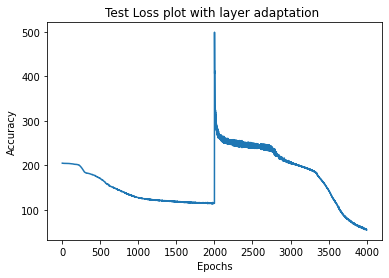

In [82]:
    import matplotlib.pyplot as plt
    
    storage_loss_array=[]
    
    no_epoch=hyperp.num_epochs
    
    for i in range(2,4):
    
        trainable_hidden_layer_index=i
    
    
        name=file_paths.NN_savefile_name + "_metrics_hl" + str(trainable_hidden_layer_index) +str(1)+ '.csv'


        df_metrics =pd.read_csv(name)

        array_metrics = df_metrics.to_numpy()

        
 
        storage_loss_array=np.concatenate((storage_loss_array, array_metrics[:,0]), axis=0)
    
    fig_accuracy = plt.figure()
    x_axis = np.linspace(1, len(storage_loss_array), len(storage_loss_array), endpoint = True)
    plt.plot(x_axis, storage_loss_array)
    #plt.ylim(-5, 60)

#plt.title('Accuracy for: ' + run_options.filename)
    plt.title('Test Loss plot with layer adaptation ')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')


In [10]:
data_train

<tf.Tensor: id=16693, shape=(5000, 2), dtype=float32, numpy=
array([[0.696799  , 0.5       ],
       [0.        , 0.15995109],
       [0.74418575, 0.5       ],
       ...,
       [0.5982862 , 0.5       ],
       [0.        , 0.6563306 ],
       [1.        , 0.18497042]], dtype=float32)>

In [12]:
tf.math.reduce_sum(tf.keras.losses.MSE(Solution, pred))

<tf.Tensor: id=6744890, shape=(), dtype=float32, numpy=178.8639>

In [22]:
G=tf.linalg.inv(Stiffness)

KeyboardInterrupt: 

In [28]:
    trainable=2
    #=== Hyperparameters and Run Options ===#    
    hyperp = Hyperparameters()
    hyperp_new=Hyperparameters_new()
    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed)               
    
 

In [14]:
len(data_train)

4000

<Figure size 432x288 with 0 Axes>

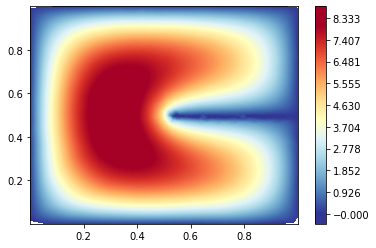

In [14]:
plot_sine(hyperp,hyperp_new, data_test, run_options, data_input_shape, label_dimensions,2,data_train, labels_train,labels_test)
        

In [8]:
labels_train

array([3, 0, 3, ..., 4, 1, 0], dtype=int32)

In [15]:
    Coordinates = loadmat('Coordinates.mat')
    Coordinates=np.array(list(Coordinates.values()))[-1]
    Coordinates = tf.cast(Coordinates,tf.float32)
    
    
    Stiffness = loadmat('Stiffness.mat')
    Stiffness=np.array(list(Stiffness.values()))[-1]
    Stiffness = tf.cast(Stiffness,tf.float32)
    
    load = loadmat('observation.mat')
    load=np.array(list(load.values()))[-1]
    load=tf.cast(load,tf.float32)
    load=tf.reshape(load,(len(load),1))

In [17]:
    solution = loadmat('Solution.mat')
    solution=np.array(list(solution.values()))[-1]
    solution=tf.cast(solution,tf.float32)
    solution=tf.reshape(solution,(len(solution),1))

In [20]:
tf.math.reduce_sum(tf.keras.losses.MSE(load, loss))

<tf.Tensor: id=5127044, shape=(), dtype=float32, numpy=2.9658818e-09>

In [9]:
loss=tf.matmul(Stiffness, Solution)

In [12]:
        #loss=tf.matmul(Stiffness, pred)
        pred,new = NN(Coordinates)
        X=tf.matmul(tf.transpose(pred-Solution),tf.transpose(Stiffness))
        Y=tf.matmul(X,Stiffness)
        Z=tf.matmul(Y,pred-Solution)

In [13]:
Z

<tf.Tensor: id=7178056, shape=(1, 1), dtype=float32, numpy=array([[251.45015]], dtype=float32)>

In [11]:
import mat4py as m4p
bb=list(loss)
load = {'x': bb}
m4p.savemat('observation.mat', load)

ValueError: Only dicts, two dimensional numeric, and char arrays are currently supported

In [13]:
loss_final=tf.math.reduce_sum(loss_new)

In [17]:
pred,l=NN(Coordinates )

In [18]:
pred

<tf.Tensor: id=17715, shape=(961, 1), dtype=float32, numpy=
array([[0.9965409 ],
       [0.97466844],
       [1.016253  ],
       [0.95278144],
       [0.9943896 ],
       [1.0359524 ],
       [0.9308796 ],
       [0.97251153],
       [1.0140978 ],
       [1.0556387 ],
       [0.90896285],
       [0.9506185 ],
       [0.99222857],
       [1.0337929 ],
       [1.0753115 ],
       [0.8870313 ],
       [0.9287108 ],
       [0.9703443 ],
       [1.0119323 ],
       [1.0534745 ],
       [1.0949715 ],
       [0.8650848 ],
       [0.9067881 ],
       [0.94844544],
       [0.9900569 ],
       [1.0316228 ],
       [1.0731431 ],
       [1.1146182 ],
       [0.8431233 ],
       [0.88485044],
       [0.92653155],
       [0.9681667 ],
       [1.0097562 ],
       [1.0513002 ],
       [1.0927986 ],
       [1.1342517 ],
       [0.82114685],
       [0.8628979 ],
       [0.90460277],
       [0.94626164],
       [0.98787487],
       [1.0294422 ],
       [1.0709642 ],
       [1.1124408 ],
       [1.153872

In [13]:
len(Solution)

2601

In [7]:
    load = loadmat('observation.mat')
    load=np.array(list(load.values()))[-1]
    load=tf.cast(load,tf.float32)
    load=tf.reshape(load,(len(load),1))

In [8]:
len(load)

961